In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


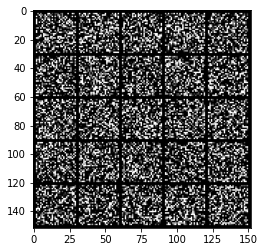

In [3]:
#checking the show_tensor_images function
tensor = torch.randn((25,28,28))
show_tensor_images(tensor)

In [4]:
def get_noise(n_samples,z_dim):
  '''
  Function to get random noise vector.
  creates a tensor of shape(batch,Z-dim) filled with random numbers from the normal distribution.
  Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
  ''' 

  return torch.randn(n_samples,z_dim, device=device)

In [5]:
def get_generator_block(input_dim, output_dim):
  '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
  return nn.Sequential(nn.Linear(input_dim,output_dim),
                       nn.BatchNorm1d(output_dim),
                       nn.ReLU(inplace=True)
                       )

In [6]:
class Generator(nn.Module):
  '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
  def __init__(self,z_dim=10,im_dim=784,hidden_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        get_generator_block(z_dim, hidden_dim),
        get_generator_block(hidden_dim, hidden_dim * 2),
        get_generator_block(hidden_dim * 2, hidden_dim * 4),
        get_generator_block(hidden_dim * 4, hidden_dim * 8),
        nn.Linear(hidden_dim*8,im_dim),
        nn.Sigmoid()
        )
    
  def forward(self,noise):
    return self.gen(noise)
  

In [7]:
def get_discriminator_block(input_dim,output_dim):
  '''
    Function for returning a block of the discriminator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by a relu activation
    '''
  return nn.Sequential(
        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [8]:
class Discriminator(nn.Module):
  '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
  def __init__(self, im_dim=784, hidden_dim=128):
    super().__init__()
    self.disc = nn.Sequential(
        get_discriminator_block(im_dim, hidden_dim * 4),
        get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
        get_discriminator_block(hidden_dim * 2, hidden_dim),
        nn.Linear(hidden_dim,1)
            )

  def forward(self,image):
    return self.disc(image)

In [9]:
#settting parameters

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 32
lr = 0.00001

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [10]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [11]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [12]:
def get_generator_loss(gen, disc, num_images, z_dim):
  '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
  noise = get_noise(num_images,z_dim)
  g_z = gen(noise)
  d_out = disc(g_z)
  gen_loss = criterion(d_out,torch.ones_like(d_out))
  return gen_loss

In [15]:
def get_discriminator_loss(gen, disc, real, num_images, z_dim):
  '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
  noise = get_noise(num_images,z_dim)
  g_z = gen(noise)
  d_out = disc(g_z.detach())

  fake_loss = criterion(d_out, torch.zeros_like(d_out)) 
  real_loss = criterion(disc(real),torch.ones_like(d_out))

  return (fake_loss + real_loss)/2

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 500: Generator loss: 1.6554927577972416, discriminator loss: 0.31741969305276896


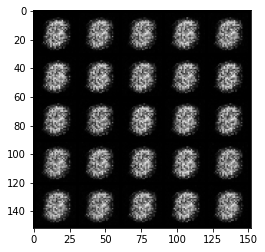

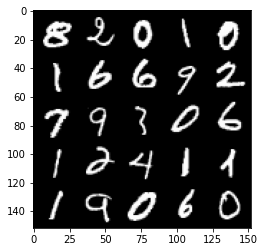

Step 1000: Generator loss: 1.9316229546070105, discriminator loss: 0.1817709387540817


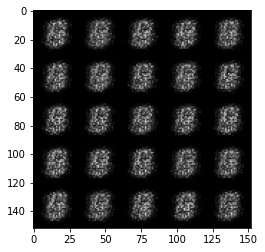

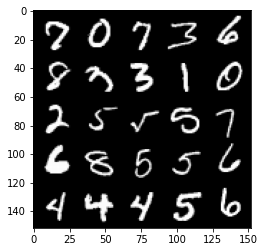

Step 1500: Generator loss: 1.8124911348819737, discriminator loss: 0.1703099361509083


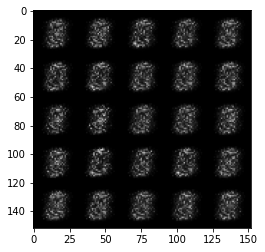

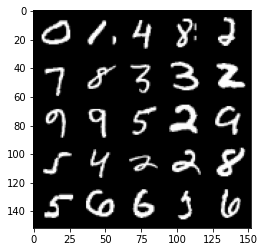

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7407192580699924, discriminator loss: 0.18127747465670088


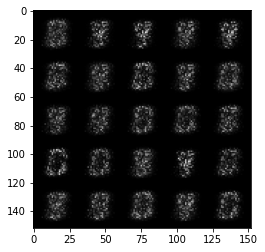

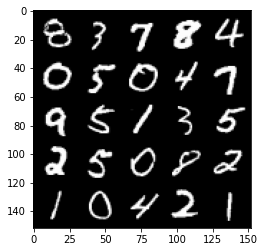

Step 2500: Generator loss: 2.008740200519562, discriminator loss: 0.14018475821614243


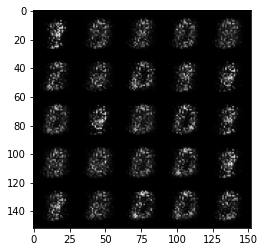

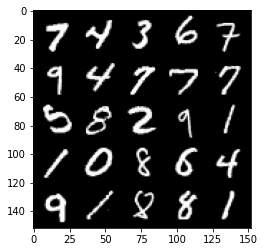

Step 3000: Generator loss: 2.3022777462005606, discriminator loss: 0.13644906325638295


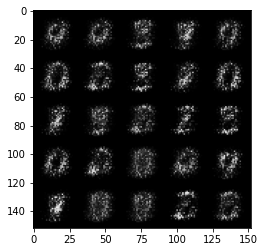

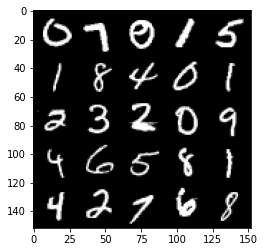

Step 3500: Generator loss: 2.4813587117195115, discriminator loss: 0.1475592572093008


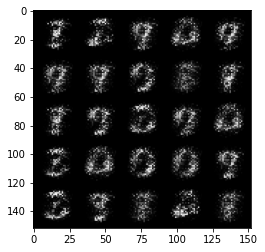

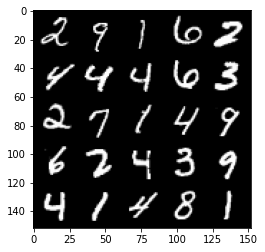

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.7715220661163347, discriminator loss: 0.1440064248144626


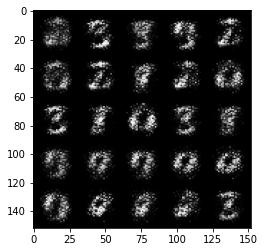

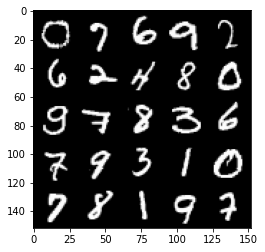

Step 4500: Generator loss: 2.9491102213859546, discriminator loss: 0.12714858694374553


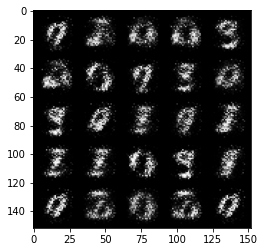

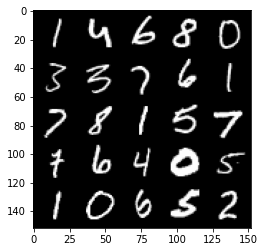

Step 5000: Generator loss: 3.266077810287474, discriminator loss: 0.10310538268834349


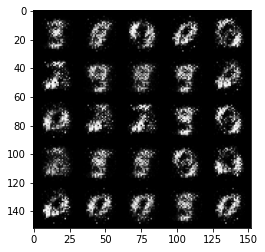

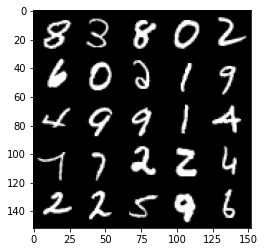

Step 5500: Generator loss: 3.394057923793792, discriminator loss: 0.08601284562423829


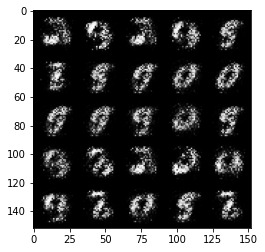

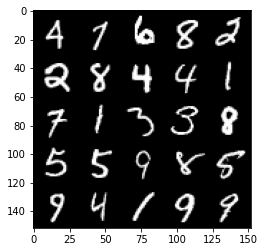

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.6086830530166636, discriminator loss: 0.0876161583438516


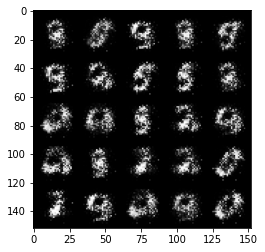

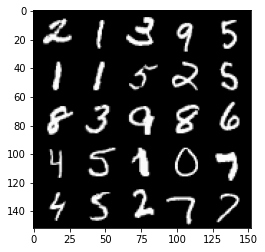

Step 6500: Generator loss: 3.3999530653953567, discriminator loss: 0.09795584501326082


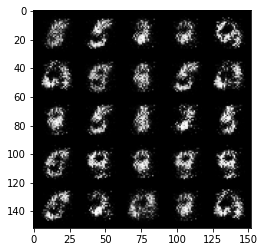

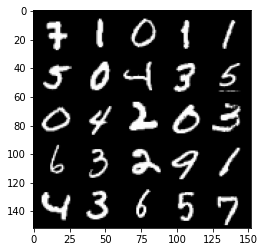

Step 7000: Generator loss: 3.6916785306930517, discriminator loss: 0.09243622294813397


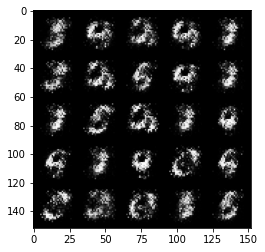

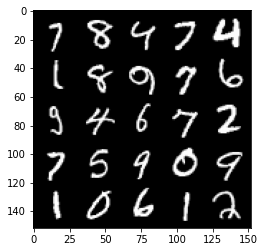

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 7500: Generator loss: 3.9099908394813516, discriminator loss: 0.08448647860810159


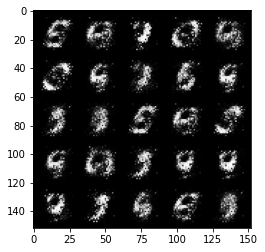

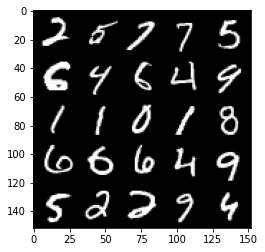

Step 8000: Generator loss: 3.891279551029207, discriminator loss: 0.06903047568723558


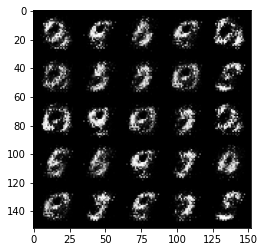

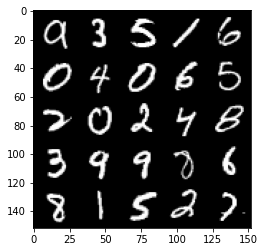

Step 8500: Generator loss: 3.9722884416580264, discriminator loss: 0.0663019904457033


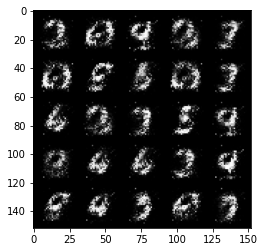

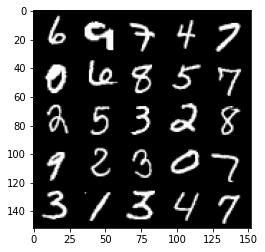

Step 9000: Generator loss: 4.0273532428741445, discriminator loss: 0.0651180405318737


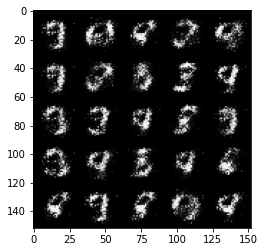

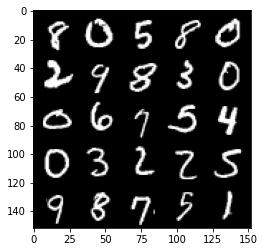

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 9500: Generator loss: 3.8928001365661618, discriminator loss: 0.06651388336345555


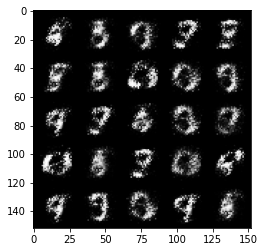

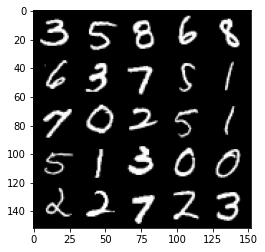

Step 10000: Generator loss: 3.7264119448661823, discriminator loss: 0.06980021205171943


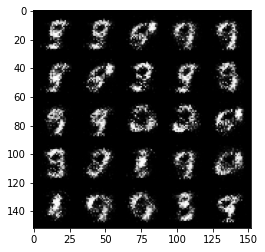

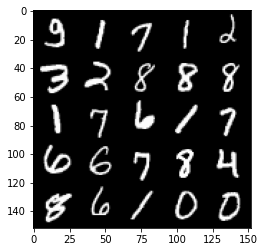

Step 10500: Generator loss: 3.6789424281120278, discriminator loss: 0.07291116175428031


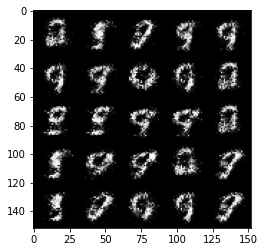

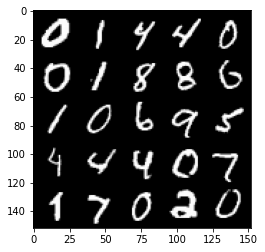

Step 11000: Generator loss: 3.862653098583222, discriminator loss: 0.07439465185999872


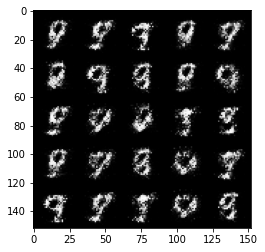

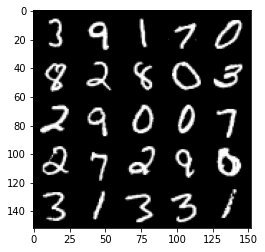

  0%|          | 0/1875 [00:00<?, ?it/s]

Step 11500: Generator loss: 3.762028061866762, discriminator loss: 0.08140875842049712


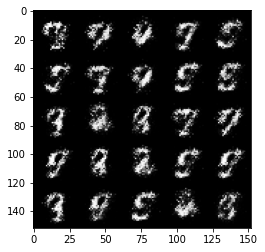

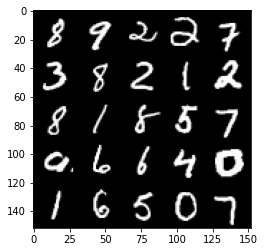

Step 12000: Generator loss: 3.6979439382553085, discriminator loss: 0.08299318075180058


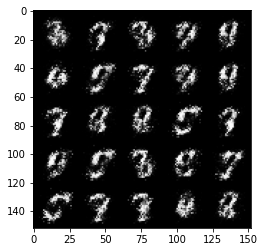

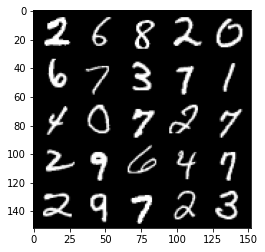

Step 12500: Generator loss: 3.8214711031913757, discriminator loss: 0.08925917227193716


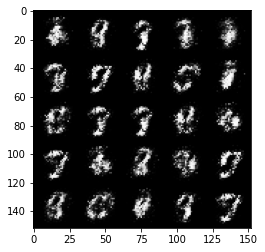

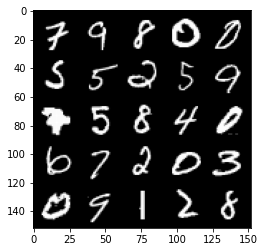

Step 13000: Generator loss: 3.901730900287633, discriminator loss: 0.07495897071063522


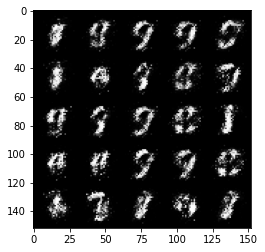

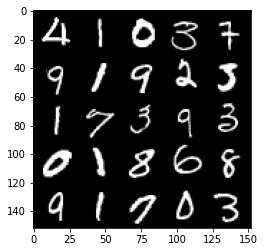

  0%|          | 0/1875 [00:00<?, ?it/s]

In [ ]:
mean_generator_loss = 0
mean_discriminator_loss = 0
cur_step = 0

for epoch in range(n_epochs):
  for real,_ in tqdm(dataloader):
    real = real.view(batch_size,-1).to(device)

    #For Discriminator
    disc_opt.zero_grad()
    disc_loss = get_discriminator_loss(gen, disc, real, batch_size, z_dim)
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    #For Generator
    gen_opt.zero_grad()
    gen_loss = get_generator_loss(gen, disc, batch_size, z_dim)
    gen_loss.backward()
    gen_opt.step()

    mean_discriminator_loss += disc_loss.item() / display_step
    mean_generator_loss += gen_loss.item() / display_step

    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
      fake_noise = get_noise(batch_size, z_dim)
      fake = gen(fake_noise)
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    
    cur_step += 1